# Deep breathing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from filterpy.kalman import predict
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from ResFunctions import *

%matplotlib inline # this makes plots inline
# %matplotlib qt   # this line makes plots float in another window

/Users/tongqi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
UsageError: unrecognized arguments: # this makes plots inline


In [2]:
import sys
sys.path.insert(1, './Kalman-and-Bayesian-Filters-in-Python/kf_book')
import book_plots as book_plots
from mkf_internal import plot_track
from filterpy.common import Saver

# 3D KF with no control functions

In [3]:
def threeDnoctrl_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements 
    model for a state [x y z dx dy dz ddx ddy ddz].T
    """

    kf = KalmanFilter(dim_x=9, dim_z=3) # no control
    
    kf.x = np.array([x[0], x[1],x[2], x[3], x[4],x[5],x[6],x[7],x[8]]) # state vector

    kf.F = np.array([[1.,0.,0., dt, 0, 0, 0.5*(dt**2), 0,  0],
                         [0.,1.,0.,0,  dt, 0 , 0, 0.5*(dt**2), 0],
                         [0.,0.,1., 0., 0, dt, 0, 0, 0.5*(dt**2)],
                         [0.,0., 0., 1., 0, 0,dt, 0, 0 ],
                         [0.,0., 0., 0., 1, 0,0, dt, 0 ],
                         [0.,0., 0., 0., 0, 1, 0, 0, dt],
                         [0, 0, 0, 0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 1]])  # state transition matrix with no control
    
    
    kf.H = np.array([[1., 0., 0., 0.,0., 0, 0, 0, 0],
                    [0., 1., 0., 0., 0., 0, 0, 0, 0],
                    [0., 0., 1., 0., 0., 0, 0, 0, 0]])    # Measurement function with no control
        
    kf.R *= R                     # measurement uncertainty
#     kf.B = np.array([[0.5*(dt**2), 0, 0],
#                      [0, 0.5*(dt**2), 0],
#                      [0, 0, 0.5*(dt**2)],
#                      [dt, 0, 0],
#                      [0 , dt, 0],
#                      [0., 0., dt]]) # control matrix
    
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=4, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

def run2(x0=(0.,0.,0.,0.), P=0, R=0, Q=0, dt=1.0, 
        track=None, zs=None, u=None,
        count=0, do_plot=False, **kwargs):
    """
    track is the actual position, zs are the 
    corresponding measurements. 
    """
    # create the Kalman filter
    kf = threeDnoctrl_filter(x0, R=R, P=P, Q=Q, dt=dt)  
    s = Saver(kf)
    
    # run the kalman filter and store the results
    xs, cov = [], []
    for index, row in zs.iterrows():
        z =[row['x'],row['y'],row['z']]
        kf.predict()
        kf.update(z)
        s.save()
        xs.append(kf.x)
        cov.append(kf.P)
    
    xs, cov = np.array(xs), np.array(cov)
    Ms, Ps, _, _ = kf.rts_smoother(xs, cov)   
        

    
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
        
    return xs, cov, s , Ms, Ps

# KF with jerk model functions

In [4]:
def jerk_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements 
    model for a state [x y z dx dy dz ddx ddy ddz dddx dddy dddz].T
    """

    kf = KalmanFilter(dim_x=12, dim_z=3) # no control
    
    kf.x = np.array([x[0], x[1],x[2], x[3], x[4],x[5],x[6],x[7],x[8], x[9],x[10],x[11]]) # state vector
    
    a = np.array([[1, dt, dt**2/2, dt**3/6],
                 [0, 1, dt, dt**2/2],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
    b = np.zeros(16).reshape(4,4)
    line1 = np.hstack((a,b,b))
    line2 = np.hstack((b,a,b))
    line3 = np.hstack((b,b,a))

    kf.F = np.vstack((line1,line2,line3)) # state transition matrix
    
    kf.H = np.array([[1., 0., 0., 0.,0., 0, 0, 0, 0,0,0,0],
                    [0., 0., 0., 0., 1., 0, 0, 0, 0,0,0,0],
                    [0., 0., 0., 0., 0., 0, 0, 0, 1,0,0,0]])    # Measurement function with no control
        
    kf.R *= R                     # measurement uncertainty
#     kf.B = np.array([[0.5*(dt**2), 0, 0],
#                      [0, 0.5*(dt**2), 0],
#                      [0, 0, 0.5*(dt**2)],
#                      [dt, 0, 0],
#                      [0 , dt, 0],
#                      [0., 0., dt]])   # control matrix
    
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=4, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

def run3(x0=(0.,0.,0.,0.), P=0, R=0, Q=0, dt=1.0, 
        track=None, zs=None, u=None,
        count=0, do_plot=False, **kwargs):
    """
    track is the actual position, zs are the 
    corresponding measurements. 
    """
    # create the Kalman filter
    kf = jerk_filter(x0, R=R, P=P, Q=Q, dt=dt)  
    s = Saver(kf)
    
    # run the kalman filter and store the results
    xs, cov = [], []
    for index, row in zs.iterrows():
        z =[row['x'],row['y'],row['z']]
        kf.predict()
        kf.update(z)
        s.save()
        xs.append(kf.x)
        cov.append(kf.P)
        
    xs, cov = np.array(xs), np.array(cov)
    Ms, Ps, _, _ = kf.rts_smoother(xs, cov)  


    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov, s , Ms, Ps

### Load data

In [5]:
# change the file location before importing the data
df_deepb = pd.read_csv("../plotterfile/Res_08032022/220803182135_deepbreath.Res", sep=" ",header=None)
dfs_withrpt,tlen = getDFS_withrpt(df_deepb)

# choose channel C
# including remove the outlier
df_deepA = dfs_withrpt[2]
df_deepA.nlargest(5, ['cost_func'])
df_deepA = df_deepA.drop(labels=754, axis=0)
df_deepA.nlargest(5, ['cost_func'])
df_deepA.head(2)
tlen

[1185, 1185, 1185, 1185]

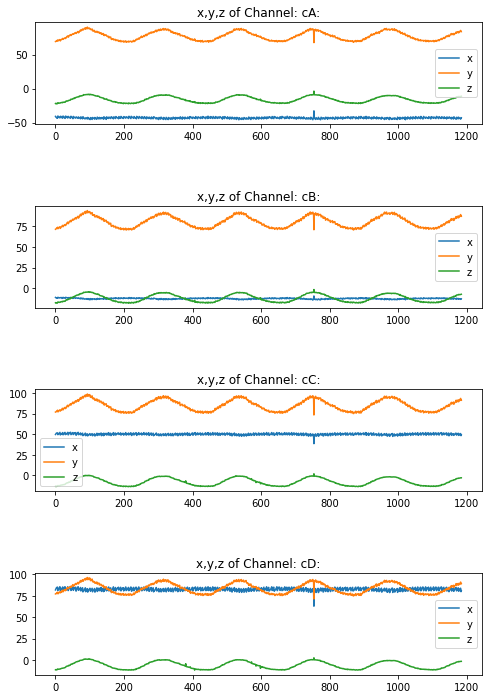

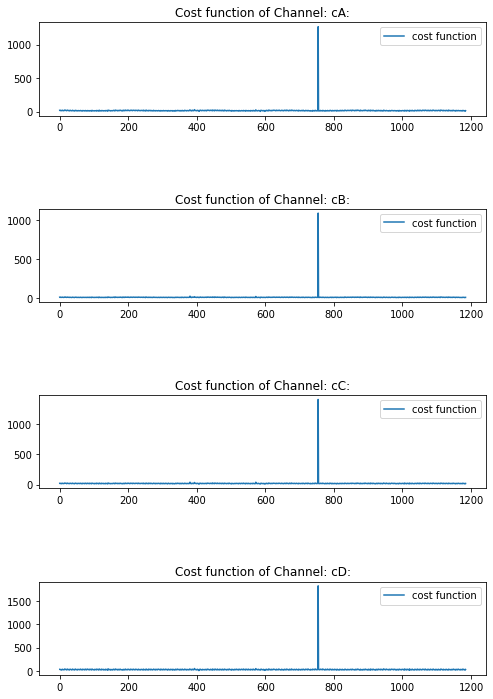

In [6]:
plotXYZ(dfs_withrpt)
plotCF(dfs_withrpt)

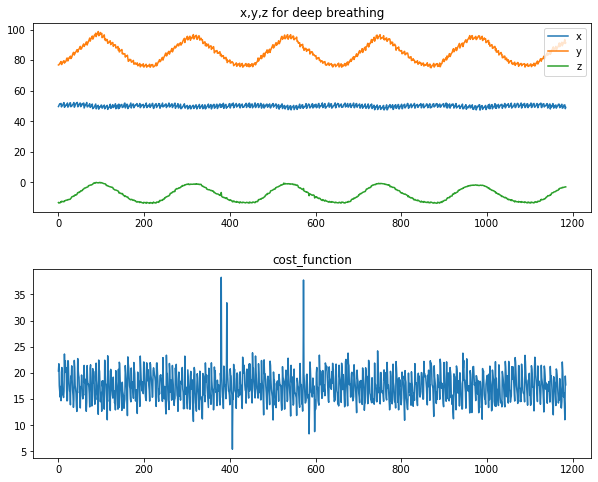

In [7]:
plot_singlesensor_xyzCF(df_deepA)

## A. KF with no control

In [8]:
dt = 0.08  
std_acc = 0.05 # very important

x = np.array([49,76,-13, 0., 0., 0.,0,0,0]) # initial values of xyz
P = np.diag([10,11,12, 12,13,14,12,12,12 ]) # initial 
Q = np.array([[(dt**5)/20, 0, 0, (dt**4)/8, 0, 0, (dt**3)/6, 0, 0],
              [0, (dt**5)/20, 0, 0, (dt**4)/8, 0,  0,(dt**3)/6, 0],
              [0,  0,(dt**5)/420, 0, 0, (dt**4)/8, 0, 0, (dt**3)/6],
              [(dt**4)/8, 0, 0, dt**3/3, 0, 0, dt**2/2, 0, 0],
              [0, (dt**4)/8, 0, 0, dt**3/3, 0, 0, dt**2/2, 0],
              [0,  0,(dt**4)/28, 0, 0, dt**3/3, 0, 0, dt**2/2],
              [(dt**3)/6, 0, 0, dt**2/2, 0, 0, dt, 0, 0],
              [0, (dt**3)/6, 0, 0, dt**2/2, 0, 0, dt, 0],
              [0, 0, (dt**3)/6, 0, 0, dt**2/2, 0, 0, dt]]) * std_acc**2 # process noise

# measurement noise variance
R = np.diag([0.030602156241616125,0.020018152918693757, 0.004661245832154307 ]) 
u=0;B=0

# the dataset put into the model
zs = df_deepA[['x','y','z']]

xs, cov, record, Ms, Ps = run2(x0=x,dt=dt,u = u, R = R, Q=Q, P=P, zs=zs,track = 0,B=B, count=len(zs))

record.to_array()

### Plot the filter value and measurments together 

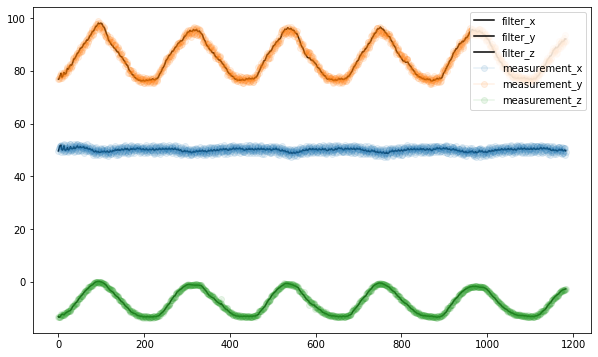

In [9]:
plt.figure(figsize=(10,6))
plt.plot(record.x[:,0],label = 'filter_x',color = "black")
plt.plot(record.x[:,1],label = 'filter_y', color = "black")
plt.plot(record.x[:,2],label = 'filter_z', color = "black")

plt.plot(record.z[:,0],label = 'measurement_x',marker = "o",alpha=0.1)
plt.plot(record.z[:,1],label = 'measurement_y', marker = "o",alpha=0.1)
plt.plot(record.z[:,2],label = 'measurement_z', marker = "o",alpha=0.1)

plt.legend(loc="best")
#plt.savefig("deep_noctrl_compare")


### Caculate the MSE of x and y and z

In [10]:
mse_x = mean_squared_error(zs['x'], list(zip(*record.x))[0])
mse_y = mean_squared_error(zs['y'], list(zip(*record.x))[1])
mse_z = mean_squared_error(zs['z'], list(zip(*record.x))[2])
print('MSE of x is ', mse_x)
print('MSE of y is ', mse_y)
print('MSE of z is ', mse_z)

MSE of x is  0.7381085514704712
MSE of y is  0.730544342668233
MSE of z is  0.06238182639956953


### Draw the errors 

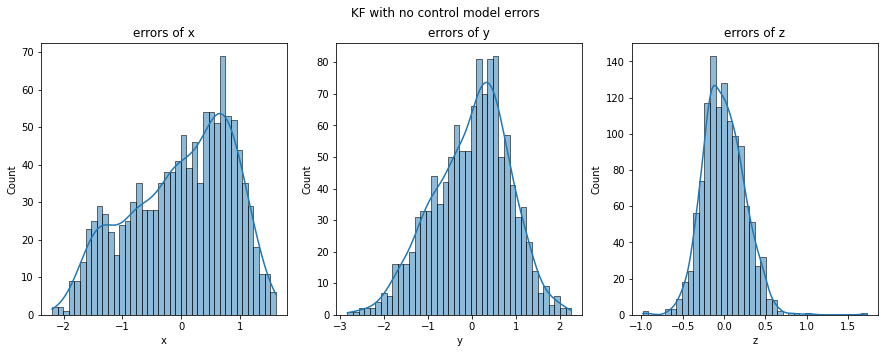

In [11]:
x_error = zs['x']- list(zip(*record.x))[0]
y_error = zs['y']- list(zip(*record.x))[1]
z_error = zs['z']- list(zip(*record.x))[2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('KF with no control model errors')
sns.histplot(ax=axes[0],x= x_error, bins=40, kde=True)
axes[0].set_title('errors of x')
sns.histplot(ax=axes[1],x= y_error, bins=40, kde=True)
axes[1].set_title('errors of y')
sns.histplot(ax=axes[2],x= z_error, bins=40, kde=True)
axes[2].set_title('errors of z');

#plt.savefig("deep_noctrl_error")

### Draw the Kalman Gain

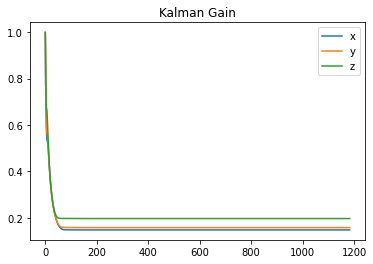

In [12]:
KalmanGain = []
for i in range(len(record.K)):
    KalmanGain.append([record.K[i][0,0],record.K[i][1,1],record.K[i][2,2]])
KalmanGain= np.vstack(KalmanGain)
KalmanGain = pd.DataFrame(KalmanGain, columns=['x','y','z'])
p1 = KalmanGain.plot(title="Kalman Gain")
#p1.figure.savefig("deep_noctrl_KG")

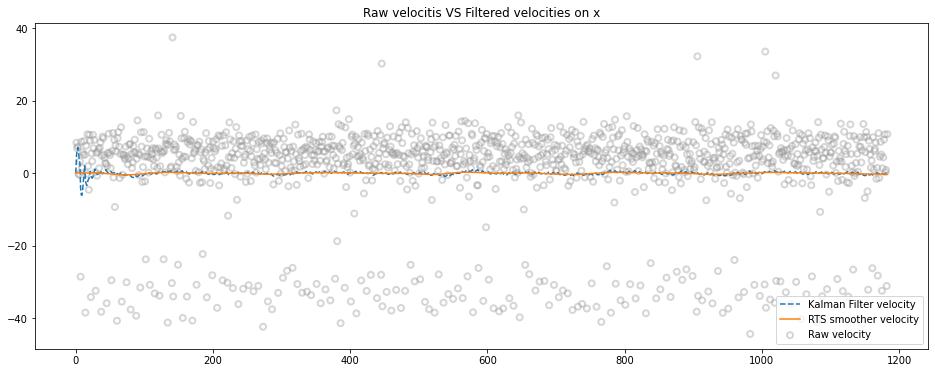

In [13]:
dx = np.diff(zs['x'], axis=0)
#ddx = np.diff(dx, axis=0)
plt.figure(figsize=(16,6))
plt.scatter(range(1, len(dx) + 1), dx*12.5, facecolor='none', 
            edgecolor='#999999', lw=2, label='Raw velocity',alpha=0.4)
plt.plot(record.x[:, 3], ls='--', label='Kalman Filter velocity')
plt.plot(Ms[:, 3], label='RTS smoother velocity')
plt.title("Raw velocitis VS Filtered velocities on x")
plt.legend(loc=4);

Text(0.5, 1.0, 'Raw velocitis VS Filtered velocities on y')

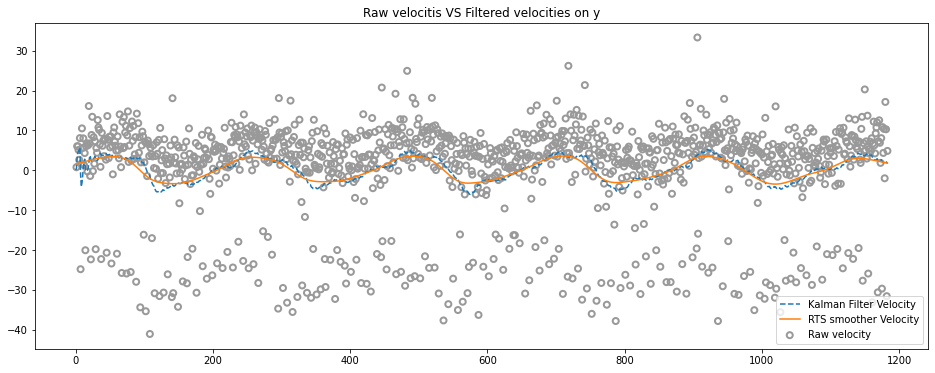

In [14]:
dy = np.diff(zs['y'], axis=0)
#ddy = np.diff(dy, axis=0)
plt.figure(figsize=(16,6))
plt.scatter(range(1, len(dy) + 1), dy*12.5, facecolor='none', 
            edgecolor='#999999', lw=2, label='Raw velocity')
plt.plot(record.x[:, 4], ls='--', label='Kalman Filter Velocity')
plt.plot(Ms[:, 4], label='RTS smoother Velocity')
plt.legend(loc=4);
plt.title("Raw velocitis VS Filtered velocities on y")
#plt.savefig("deep_nocontrol_y.png")

Text(0.5, 1.0, 'Raw velocitis VS Filtered velocities on z')

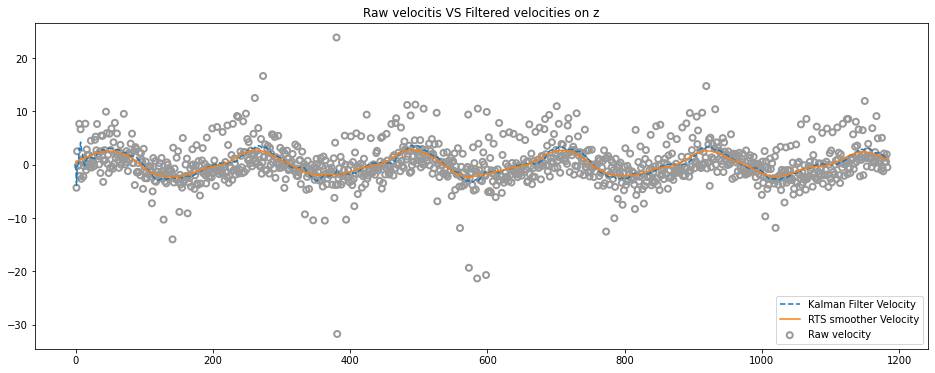

In [15]:
dz = np.diff(zs['z'], axis=0)
plt.figure(figsize=(16,6))
plt.scatter(range(1, len(dz) + 1), dz*12.5, facecolor='none', 
            edgecolor='#999999', lw=2, label='Raw velocity')
plt.plot(record.x[:, 5], ls='--', label='Kalman Filter Velocity')
plt.plot(Ms[:, 5], label='RTS smoother Velocity')
plt.legend(loc=4);
plt.title("Raw velocitis VS Filtered velocities on z")
#plt.savefig("deep_nocontrol_z.png")

## Forward prediction with KF no control model

In [16]:
zs_train, zs_test = train_test_split(zs, test_size= 0.1, shuffle=False)
print(len(zs_train),len(zs_test))

1065 119


### update KF till the train set

In [17]:
dt = 0.08  # very important
std_acc = 0.05

x = np.array([49,76,-13, 0., 0., 0.,0,0,0])
P = np.diag([10,11,12, 12,13,14,12,12,12 ]) 
Q = np.array([[(dt**5)/20, 0, 0, (dt**4)/8, 0, 0, (dt**3)/6, 0, 0],
              [0, (dt**5)/20, 0, 0, (dt**4)/8, 0,  0,(dt**3)/6, 0],
              [0,  0,(dt**5)/420, 0, 0, (dt**4)/8, 0, 0, (dt**3)/6],
              [(dt**4)/8, 0, 0, dt**3/3, 0, 0, dt**2/2, 0, 0],
              [0, (dt**4)/8, 0, 0, dt**3/3, 0, 0, dt**2/2, 0],
              [0,  0,(dt**4)/28, 0, 0, dt**3/3, 0, 0, dt**2/2],
              [(dt**3)/6, 0, 0, dt**2/2, 0, 0, dt, 0, 0],
              [0, (dt**3)/6, 0, 0, dt**2/2, 0, 0, dt, 0],
              [0, 0, (dt**3)/6, 0, 0, dt**2/2, 0, 0, dt]]) * std_acc**2 # process noise
R = np.diag([0.030602156241616125,0.020018152918693757, 0.004661245832154307 ])
u=0;B=0

zs = zs_train

xs, cov, record, Ms, Ps = run2(x0=x,dt=dt,u = u, R = R, Q=Q, P=P, zs=zs,track = 0,B=B, count=len(zs))

record.to_array()

In [18]:
from filterpy.kalman import predict

x = xs[-1]
pred = []
for _ in range(len(zs_test)):
    x, P = predict(x=x, P=record.P[-1], F=record.F[-1], Q=record.Q[-1])
    pred.append(x)
    
pred = np.vstack(pred)

In [19]:
def Extract0(lst):
    return [item[0] for item in lst]
def Extract1(lst):
    return [item[1] for item in lst]
def Extract2(lst):
    return [item[2] for item in lst]
def Extract4(lst):
    return [item[4] for item in lst]
def Extract8(lst):
    return [item[8] for item in lst]

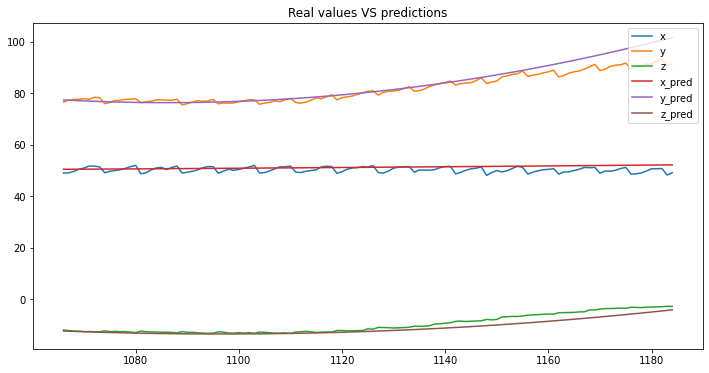

In [20]:
#zs_test.loc[:,'x_pred'] = Extract0(pred)
zs_test['x_pred'] = Extract0(pred)
zs_test['y_pred'] = Extract1(pred)
zs_test['z_pred'] = Extract2(pred)
p_pred = zs_test.plot(figsize=(12, 6),title="Real values VS predictions")

#plt.savefig("deep_nocontrl_pred1")

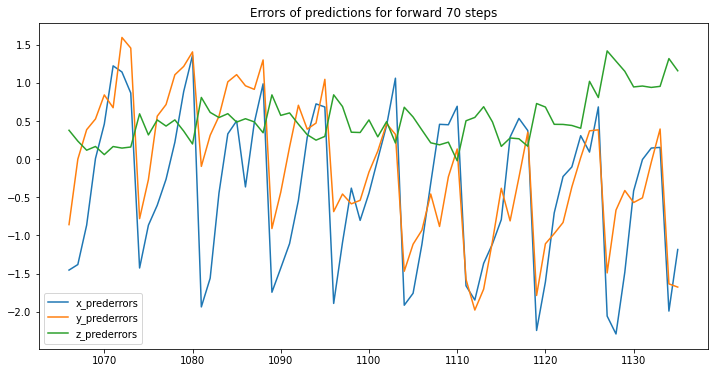

In [21]:
pred_errors = pd.DataFrame()
pred_errors['x_prederrors'] = zs_test['x'] - zs_test['x_pred']
pred_errors['y_prederrors'] = zs_test['y'] - zs_test['y_pred']
pred_errors['z_prederrors'] = zs_test['z'] - zs_test['z_pred']
pred_error_plot = pred_errors[0:70].plot(figsize=(12, 6),title = "Errors of predictions for forward 70 steps")

#plt.savefig("deep_nocontrl_pred2")

## B. KF with jerk model

In [22]:
dt = 0.08 # very important
std_jerk = 0.05
alpha = 1 # correlation parameter

x = np.array([21, 0,0, 0., 127, 0.,0,0,54,0,0,0]) # initial positions
P = np.diag([10,11,12, 13,10,14,12,12,10,14,14,14 ]) # covariance of estimates
sq = np.array([[dt**7/252, dt**6/72, dt**5/30, dt**4/24],
               [dt**6/722, dt**5/30, dt**4/24, dt**3/6],
               [dt**5/30, dt**4/24, dt**3/6, dt**2/2],
               [dt**4/24, dt**3/6, dt**2/2, dt]])
b = np.zeros(16).reshape(4,4)
Q = np.vstack((np.hstack((sq,b,b)), np.hstack((b,sq,b)),np.hstack((b,b,sq))))* alpha * std_jerk**2

R = np.diag([0.030602156241616125,0.020018152918693757, 0.004661245832154307 ])
u=0;B=0

zs = df_deepA[['x','y','z']] #~!!!!!!!!!!!!!!!!!!1

xs, cov, record, Ms, Ps = run3(x0=x,dt=dt,u = u, R = R, Q=Q, P=P, zs=zs,track = 0,B=B, count=len(zs))
record.to_array()

### Plot the filter value and measurments together 

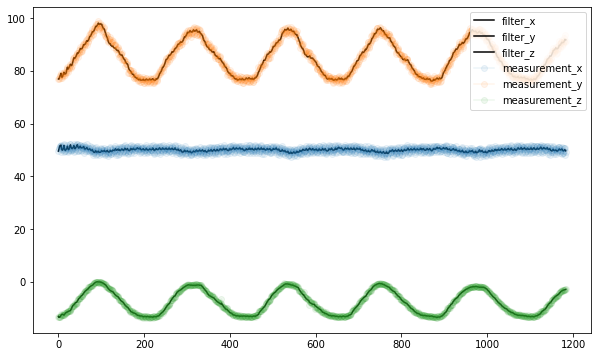

In [23]:
plt.figure(figsize=(10,6))
plt.plot(record.x[:,0],label = 'filter_x',color = "black")
plt.plot(record.x[:,4],label = 'filter_y', color = "black")
plt.plot(record.x[:,8],label = 'filter_z', color = "black")

plt.plot(record.z[:,0],label = 'measurement_x',marker = "o",alpha=0.08)
plt.plot(record.z[:,1],label = 'measurement_y', marker = "o",alpha=0.08)
plt.plot(record.z[:,2],label = 'measurement_z', marker = "o",alpha=0.08)

plt.legend(loc="best")
#plt.savefig("deep_jerk_compare.png")

### Caculate the MSE of x and y and z

In [24]:
mse_x = mean_squared_error(zs['x'], list(zip(*record.x))[0])
mse_y = mean_squared_error(zs['y'], list(zip(*record.x))[4])
mse_z = mean_squared_error(zs['z'], list(zip(*record.x))[8])
print('MSE of x is ', mse_x)
print('MSE of y is ', mse_y)
print('MSE of z is ', mse_z)


MSE of x is  0.6987173036897787
MSE of y is  0.6527513198115568
MSE of z is  0.05495759862873113


## Draw the errors

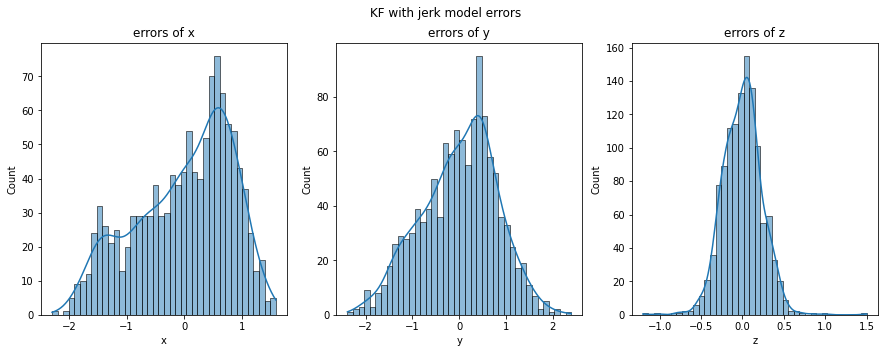

In [25]:
x_error = zs['x']- list(zip(*record.x))[0]
y_error = zs['y']- list(zip(*record.x))[4]
z_error = zs['z']- list(zip(*record.x))[8]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('KF with jerk model errors')
sns.histplot(ax=axes[0],x= x_error, bins=40, kde=True)
axes[0].set_title('errors of x')
sns.histplot(ax=axes[1],x= y_error, bins=40, kde=True)
axes[1].set_title('errors of y')
sns.histplot(ax=axes[2],x= z_error, bins=40, kde=True)
axes[2].set_title('errors of z');

#plt.savefig("deep_jerk_error")

### Draw the Kalman Gain

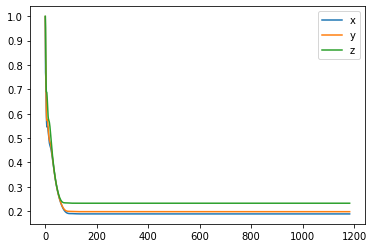

In [26]:
KalmanGain = []
for i in range(len(record.K)):
    KalmanGain.append([record.K[i][0,0],record.K[i][4,1],record.K[i][8,2]])
KalmanGain= np.vstack(KalmanGain)
KalmanGain = pd.DataFrame(KalmanGain, columns=['x','y','z'])
p1 = KalmanGain.plot()
#p1.figure.savefig("deep_jerk_KG.png")

Text(0.5, 1.0, 'Raw velocitis VS Filtered velocities on x')

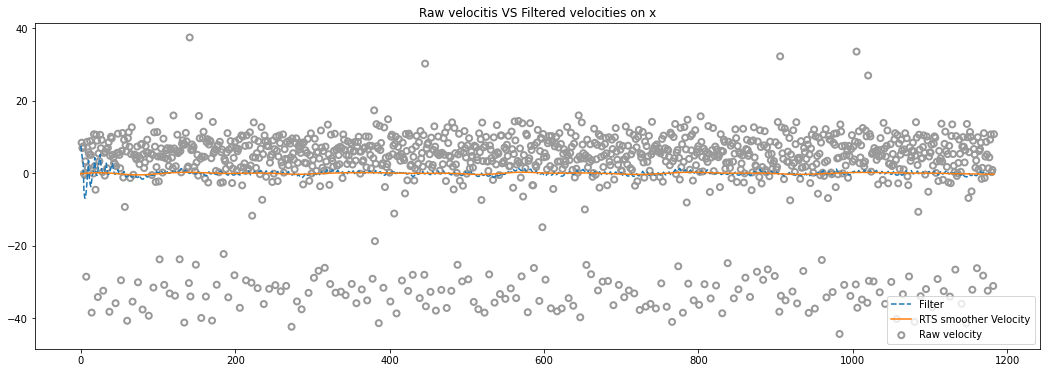

In [27]:
dx = np.diff(zs['x'], axis=0)
plt.figure(figsize=(18,6))
plt.scatter(range(1, len(dx) + 1), dx*12.5, facecolor='none', 
            edgecolor='#999999', lw=2, label='Raw velocity')
plt.plot(record.x[3:, 1], ls='--', label='Filter')
plt.plot(Ms[:, 1], label='RTS smoother Velocity')
plt.legend(loc=4)
plt.title("Raw velocitis VS Filtered velocities on x")

Text(0.5, 1.0, 'Raw velocitis VS Filtered velocities on y')

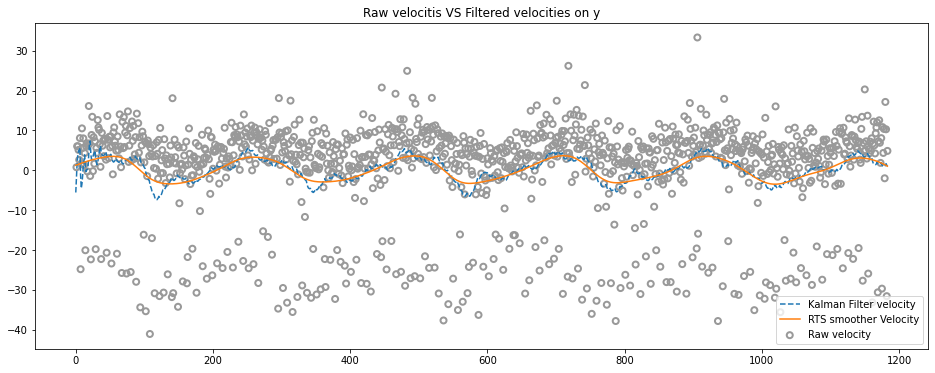

In [28]:
dy = np.diff(zs['y'], axis=0)
plt.figure(figsize=(16,6))
plt.scatter(range(1, len(dy) + 1), dy*12.5, facecolor='none', 
            edgecolor='#999999', lw=2, label='Raw velocity')
plt.plot(record.x[:, 5], ls='--', label='Kalman Filter velocity')
plt.plot(Ms[:, 5], label='RTS smoother Velocity')
plt.legend(loc=4);
plt.title("Raw velocitis VS Filtered velocities on y")
#plt.savefig('deep_jerk_y.png')

Text(0.5, 1.0, 'Raw velocitis VS Filtered velocities on z')

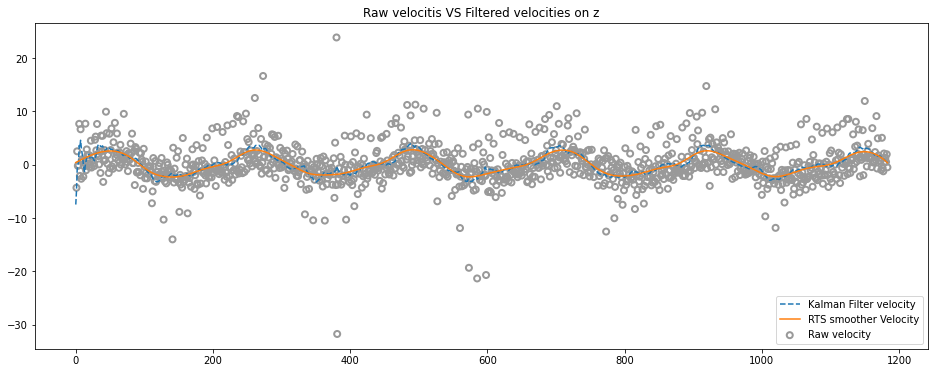

In [29]:
dz = np.diff(zs['z'], axis=0)
plt.figure(figsize=(16,6))
plt.scatter(range(1, len(dz) + 1), dz*12.5, facecolor='none', 
            edgecolor='#999999', lw=2, label='Raw velocity')
plt.plot(record.x[:, 9], ls='--', label='Kalman Filter velocity')
plt.plot(Ms[:, 9], label='RTS smoother Velocity')
plt.legend(loc=4);
plt.title("Raw velocitis VS Filtered velocities on z")
#plt.savefig('deep_jerk_z.png')

## Forward prediction with KF jerk model

In [30]:
dt = 0.08 
std_jerk = 0.05 # very important
alpha = 1 # correlation parameter

x = np.array([41, 0,0, 0., 94, 0.,0,0,-11,0,0,0]) # initial positions
P = np.diag([10,11,12, 13,10,14,12,12,10,14,14,14 ]) # covariance of estimates
sq = np.array([[dt**7/252, dt**6/72, dt**5/30, dt**4/24],
               [dt**6/722, dt**5/30, dt**4/24, dt**3/6],
               [dt**5/30, dt**4/24, dt**3/6, dt**2/2],
               [dt**4/24, dt**3/6, dt**2/2, dt]])
b = np.zeros(16).reshape(4,4)
Q = np.vstack((np.hstack((sq,b,b)), np.hstack((b,sq,b)),np.hstack((b,b,sq))))* alpha * std_jerk**2

R = np.diag([0.030602156241616125,0.020018152918693757, 0.004661245832154307 ])
u=0;B=0

zs = zs_train

xs, cov, record, Ms, Ps = run3(x0=x,dt=dt,u = u, R = R, Q=Q, P=P, zs=zs,track = 0,B=B, count=len(zs))
record.to_array()

In [31]:
from filterpy.kalman import predict

x = xs[-1]
pred = []
for _ in range(len(zs_test)):
    x, P = predict(x=x, P=record.P[-1], F=record.F[-1], Q=record.Q[-1])
    pred.append(x)
    
pred = np.vstack(pred)

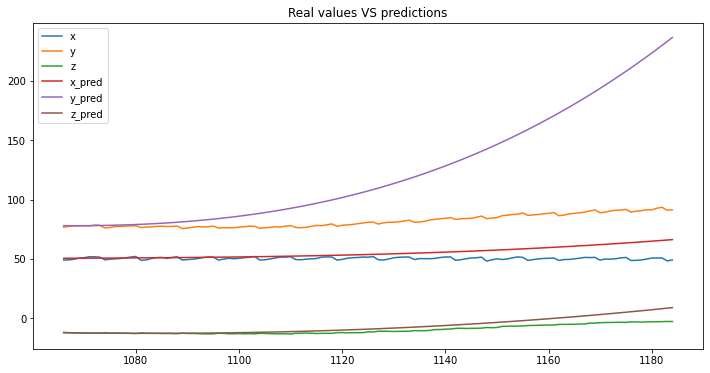

In [32]:
zs_test['x_pred'] = Extract0(pred)
zs_test['y_pred'] = Extract4(pred)
zs_test['z_pred'] = Extract8(pred)
p_pred = zs_test.plot(figsize=(12, 6), title = "Real values VS predictions")

#plt.savefig("deep_jerk_pred1")

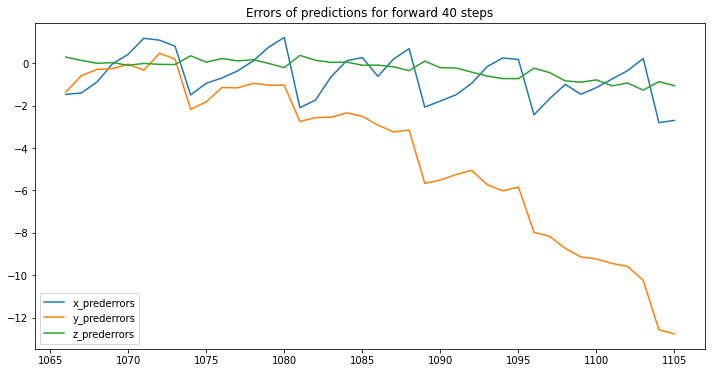

In [33]:
pred_errors = pd.DataFrame()
pred_errors['x_prederrors'] = zs_test['x'] - zs_test['x_pred']
pred_errors['y_prederrors'] = zs_test['y'] - zs_test['y_pred']
pred_errors['z_prederrors'] = zs_test['z'] - zs_test['z_pred']
pred_error_plot = pred_errors[0:40].plot(figsize=(12, 6),title = "Errors of predictions for forward 40 steps")

#plt.savefig("deep_jerk_pred2")